In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import tensorflow as tf
import numpy as np
import datetime
import os
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
image_path = '/mnt/mount_zc_NAS/MNIST/training_and_validation_batches/1.mat'
temp = loadmat(image_path)

x = temp['affNISTdata']['image'][0][0].reshape(40, 40, -1)
# make pseudo-3D image
print(x.shape)
x_3d = np.zeros((x.shape[0],x.shape[1],3, x.shape[2]))
for i in range(0,x.shape[-1]):
    x_3d[:,:,0,i] = x[:,:,i]
    x_3d[:,:,1,i] = x[:,:,i]
    x_3d[:,:,2,i] = x[:,:,i]
x = np.moveaxis(x_3d, -1, 0)
x = np.expand_dims(x, axis=-1)
x = np.tile(x,3)
print(x.shape)
x = x/255.0

y = temp['affNISTdata']['label_int'][0][0]
y = np.moveaxis(y, -1, 0)
print(y.shape)
y = y.astype(np.int32)

(40, 40, 60000)
(60000, 40, 40, 3, 3)
(60000, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train = X_train[0:1000,...]
y_train = y_train[0:1000,...]
print(X_train.shape, X_test.shape)
mnist_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
mnist_train_ds = mnist_train_ds.shuffle(50).batch(16)

In [ ]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,1))
        self.conv1 = tf.keras.layers.Conv3D(20, [3,3,1], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,1))
        self.conv2 = tf.keras.layers.Conv3D(20, [3,3,1], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((1,6))(theta)
        return theta

class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''      
      
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2] # input (batch_size, height, width, channel)
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width)) # shape (batch_size, height, width)
        indices = tf.stack([b, y, x], 3) # shape (batch_size, height, width, 3)
        
        return tf.gather_nd(inputs, indices) # Important!: shape(batch_size, height, width, 1), value of these indices in the inputs image

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width) # normalization
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y) # xx shape (height,width)
        xx = tf.reshape(xx, (-1,)) # flatten
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)]) # add the channel, shape (3, height*width)
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0) # shape (1, 3, height*width)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1]) # shape (batch_size, 3, height*width)
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates) # theta shape (2,3), coordinates shape (batch_size,3,height*width), transformed shape (batch_size, 2, height*width)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2]) # (batch_size, height, width, 2) 2 here represents x and y
            
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
    
            # previously we have converted the coordinate system into -1 to 1, here we convert it back.
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5
    
        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1
            
            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"): # bilinear interpolation
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [ ]:
class build_x_points(tf.keras.layers.Layer):
    def __init__(self,num):
        super(build_x_points, self).__init__()
        self.num = num
    
    def call(self, inputs):
        values = tf.linspace(0., 1., self.num)
        inputs_tile = tf.tile(inputs,[1, self.num // inputs.shape[-1]])
        a = tf.ones_like(inputs_tile)   # [None, 5]
        
        x_points = [tf.reshape(a[...,i] * values[i],[-1,1]) for i in range(0,a.shape[-1])]
        x_points = tf.reshape(tf.stack(x_points, axis = -1),[-1,self.num])
        return x_points

In [ ]:
class element_1D(tf.keras.layers.Layer):
    def __init__(self,index):
        super(element_1D, self).__init__()
        self.index = index
    
    def call(self, inputs):
        output = inputs[...,self.index]; output = tf.reshape(output,[-1,1])
        return output

class element_2D(tf.keras.layers.Layer):
    def __init__(self,index1, index2):
        super(element_2D, self).__init__()
        self.index1 = index1
        self.index2 = index2
    
    def call(self, inputs):
        output = inputs[...,self.index1, self.index2]; output = tf.reshape(output,[-1,1,1])
        return output

In [ ]:
class bspline_zhennong(tf.keras.layers.Layer):
    def __init__(self):
        super(bspline_zhennong, self).__init__()

    def advance_indexing_2d(self, inputs, I):
        shape = tf.shape(inputs)
        batch_size, length = shape[0], shape[1] # input (batch_size, height, width, channel)
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1))
        b = tf.tile(batch_idx, (1, length)) # shape (batch_size, height, width)
        indices = tf.stack([b, I], 2) # shape (batch_size, height, width, 3)
        
        return tf.gather_nd(inputs, indices) # Important!: shape(batch_size, height, width, 1), value of these indices in the inputs image
    
    def make_I(self,inputs):
        I = tf.zeros_like(inputs)
        I = tf.cast(I, dtype = tf.int32)
        a = tf.constant([0,0,0,1,1,2,2,3,3,3], dtype = tf.int32)
        I = I+a
        return I


    def h_poly_helper_tf(self,tt0, tt1, tt2, tt3):
  
        A = tf.constant([
            [1, 0, -3, 2],
            [0, 1, -2, 1],
            [0, 0, 3, -2],
            [0, 0, -1, 1]], dtype=tt1.dtype)

        first = A[0,0] * tt0  + A[0,1] * tt1 + A[0,2] * tt2 + A[0,3] * tt3; first = first[:,tf.newaxis,:]
        second = A[1,0] * tt0  + A[1,1] * tt1 + A[1,2] * tt2 + A[1,3] * tt3; second = second[:,tf.newaxis,:]
        third = A[2,0] * tt0  + A[2,1] * tt1 + A[2,2] * tt2 + A[2,3] * tt3; third = third[:,tf.newaxis,:]
        fourth = A[3,0] * tt0  + A[3,1] * tt1 + A[3,2] * tt2 + A[3,3] * tt3; fourth = fourth[:,tf.newaxis,:]
   
        output = tf.concat([first, second, third, fourth], axis = 1)
        return output
    
    def h_poly_tf(self,t):

        tt0 = tf.constant(1.)
        tt1 = tt0 * t # same dimension as t
        tt2 = tf.math.multiply(tt1, t) # same dimension as t
        tt3 = tf.math.multiply(tt2, t)
        return self.h_poly_helper_tf(tt0, tt1, tt2 , tt3)

    def get_I_plus_1(self,x):
        x_11 = x[...,1]; x_11 = tf.reshape(x_11,[-1,1])
        x_12 = x[...,1]; x_12 = tf.reshape(x_12,[-1,1])
        x_13 = x[...,1]; x_13 = tf.reshape(x_13,[-1,1])
        x_14 = x[...,2]; x_14 = tf.reshape(x_14,[-1,1])
        x_15 = x[...,2]; x_15 = tf.reshape(x_15,[-1,1])
        x_16 = x[...,3]; x_16 = tf.reshape(x_16,[-1,1])
        x_17 = x[...,3]; x_17 = tf.reshape(x_17,[-1,1])
        x_18 = x[...,4]; x_18 = tf.reshape(x_18,[-1,1])
        x_19 = x[...,4]; x_19 = tf.reshape(x_19,[-1,1])
        x_110 = x[...,4]; x_110 = tf.reshape(x_110,[-1,1])
        x_1 = tf.concat([x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_110],axis = -1)
        return x_1

    def get_I(self,x):
        x_11 = x[...,0]; x_11 = tf.reshape(x_11,[-1,1])
        x_12 = x[...,0]; x_12 = tf.reshape(x_12,[-1,1])
        x_13 = x[...,0]; x_13 = tf.reshape(x_13,[-1,1])
        x_14 = x[...,1]; x_14 = tf.reshape(x_14,[-1,1])
        x_15 = x[...,1]; x_15 = tf.reshape(x_15,[-1,1])
        x_16 = x[...,2]; x_16 = tf.reshape(x_16,[-1,1])
        x_17 = x[...,2]; x_17 = tf.reshape(x_17,[-1,1])
        x_18 = x[...,3]; x_18 = tf.reshape(x_18,[-1,1])
        x_19 = x[...,3]; x_19 = tf.reshape(x_19,[-1,1])
        x_110 = x[...,3]; x_110 = tf.reshape(x_110,[-1,1])
        x_2 = tf.concat([x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_110],axis = -1)
        return x_2


    def interp_func_tf(self,x, y, xs):
        m = (y[...,1:] - y[...,:-1])/(x[...,1:] - x[...,:-1])
        
        first_term = tf.reshape(m[...,0], [-1,1])
        second_term = tf.reshape((m[...,1:] + m[...,:-1])/2, [-1,3])
        third_term = tf.reshape(m[...,-1], [-1,1])
        m = tf.concat([first_term, second_term, third_term], axis = 1)
            
        # II = tf.searchsorted(x[1:], xs)  # each xs belong to which spline segment
        x_1 = self.get_I_plus_1(x)
        x_2 = self.get_I(x)
        dx = x_1 - x_2
        poly_input = (xs - x_2) / (dx)
        hh = self.h_poly_tf(poly_input)

        term1 = tf.math.multiply(hh[:,0,:],self.get_I(y))
        term2 = tf.math.multiply(tf.math.multiply(hh[:,1,:], self.get_I(m)),dx)
        term3 = tf.math.multiply(hh[:,2,:],self.get_I_plus_1(y))
        term4 = tf.math.multiply(tf.math.multiply(hh[:,3,:],self.get_I_plus_1(m)),dx)
        return  term1 + term2 + term3 + term4
        
        
    def call(self, inputs):
        x,y,xs = inputs
        output = self.interp_func_tf(x,y,xs)
        print('b-spline output shape: ', output.shape)
          
        return output

In [ ]:
def get_model(input_shape):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)

    # get theta by each neuron
    t1 = tf.zeros_like(theta[...,0,0]); t1 = tf.reshape(t1,[-1,1,1])
    t2 = element_2D(0,1)(theta) ; t3 = element_2D(0,2)(theta); t4 = element_2D(0,3)(theta)
    t5 = element_2D(0,4)(theta); t6 = element_2D(0,5)(theta)


    # # spline
    y_points = tf.reshape(tf.concat([t1, t2, t3, t4, t5], axis = 2),[-1,5])
    x_points = build_x_points(5)(y_points)
    xs = build_x_points(10)(y_points)
    ys = bspline_zhennong()([x_points, y_points, xs])

    # get theta
    yy = element_1D(0)(ys)
 
    
    first_row = tf.concat([yy,t2,t3],axis = 2)
    second_row = tf.concat([t4,t5,t6],axis = 2)
    theta_c = tf.concat([first_row,second_row],axis = 1)
 
    # do STN for each slice:
    image_r = tf.transpose(image, [3,0,1,2,4])
    array = [BilinearInterpolation(height=input_shape[0], width=input_shape[1])([ii, theta_c])for ii in image_r]
    array = tf.stack(array, axis=0)
    x = tf.transpose(array, [1,2,3,0,4])

    # x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
    x = tf.keras.layers.Conv3D(64, [9, 9, 1], activation='relu', name = 'first_conv3d')(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2,2,1))(x)
    x = tf.keras.layers.Conv3D(64, [7, 7, 1], activation='relu')(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2,2,1))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.models.Model(inputs=image, outputs=[x])

In [ ]:
model = get_model((40, 40, 3,3))
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
def schedular(epoch, lr):
    if epoch % 20 == 0 and epoch > 0:
        print("Learning Rate Updated")
        lr /= 10
    return lr
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(schedular)
history = model.fit(mnist_train_ds, epochs=100, callbacks=[tensorboard_callback, learning_rate_callback])

In [ ]:
stn = tf.keras.models.Model(inputs=model.inputs, outputs=[model.get_layer('localization_1').output, model.get_layer('tf.concat_7').output,
                            model.get_layer('tf.compat.v1.transpose_3').output])
theta, theta_change, prediction = stn.predict(X_test)
# print(x[1,...],y[1,...], xs[1,...], ys[1,...])
print(theta[1,...])
print(theta_change[1,...])
print(prediction.shape)

In [ ]:
index = 110

plt.subplot(1,2,1)
plt.title(y_test[index])
plt.imshow(X_test[index, :, :, 0,0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title(np.argmax(model.predict(np.expand_dims(X_test[index, :, :, :,:], axis=0))))
plt.imshow(prediction[index, :, :,2, 2], cmap='gray')

# print("\n", theta_original[index,...])

[-0.00019258 -0.00079463 -0.00142818 -0.00171526 -0.00127787  0.00026196
  0.00344442  0.00844496  0.01449817  0.0208084   0.02658     0.03101732
  0.03351889  0.03479887  0.03513666  0.03465575  0.03347965  0.03173186
  0.02950912  0.02639094  0.02241475  0.01787473  0.01306506  0.0082799
  0.00381342]


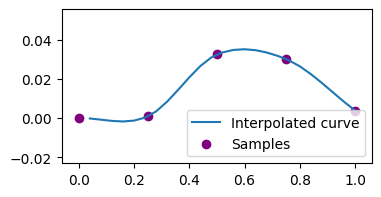

In [4]:
def h_poly_helper(tt0, tt1, tt2, tt3):
  
  A = np.array([
    [1, 0, -3, 2],
    [0, 1, -2, 1],
    [0, 0, 3, -2],
    [0, 0, -1, 1]], dtype=tt1[-1].dtype)

  first = A[0,0] * tt0  + A[0,1] * tt1 + A[0,2] * tt2 + A[0,3] * tt3
  second = A[1,0] * tt0  + A[1,1] * tt1 + A[1,2] * tt2 + A[1,3] * tt3
  third = A[2,0] * tt0  + A[2,1] * tt1 + A[2,2] * tt2 + A[2,3] * tt3
  fourth = A[3,0] * tt0  + A[3,1] * tt1 + A[3,2] * tt2 + A[3,3] * tt3
 
  output = np.asarray([first, second, third, fourth])

  return output

def h_poly(t):
 
  tt0 = 1
  tt1 = tt0 * t # same dimension as t
  tt2 = np.multiply(tt1, t) # same dimension as t
  tt3 = np.multiply(tt2, t)

  return h_poly_helper(tt0, tt1, tt2 , tt3)


def interp_func(x, y):
 
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = np.concatenate([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):

    I = np.searchsorted(x[1:], xs)  # each xs belong to which spline segment
    dx = (x[I+1]-x[I])

    hh = h_poly((xs-x[I])/dx)
    term1 = np.multiply(hh[0],y[I])
    term2 = np.multiply(np.multiply(hh[1], m[I]) ,dx)
    term3 = np.multiply(hh[2],y[I+1])
    term4 = np.multiply(np.multiply(hh[3],m[I+1]),dx)
    return term1 + term2 + term3 + term4
  return f


def interp(x, y, xs):
  return interp_func(x,y)(xs)

x = np.linspace(0, 1, 5)
y = np.asarray([0,0.00086347, 0.03248698 ,0.03012013, 0.00381342],np.float32) 
# y = y / 2 * 128
xs = np.linspace(0.04, 1,25)
ys = interp(x, y, xs)
print(ys)

plt.figure(figsize = (4,2))
plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.legend()
plt.show()

In [ ]:
# tensorflow version:
def h_poly_helper_tf(tt0, tt1, tt2, tt3):
  
  A = tf.constant([
    [1, 0, -3, 2],
    [0, 1, -2, 1],
    [0, 0, 3, -2],
    [0, 0, -1, 1]], dtype=tt1.dtype)

  first = A[0,0] * tt0  + A[0,1] * tt1 + A[0,2] * tt2 + A[0,3] * tt3; first = tf.reshape(first,[-1,1])
  second = A[1,0] * tt0  + A[1,1] * tt1 + A[1,2] * tt2 + A[1,3] * tt3; second = tf.reshape(second, [-1,1])
  third = A[2,0] * tt0  + A[2,1] * tt1 + A[2,2] * tt2 + A[2,3] * tt3; third = tf.reshape(third, [-1,1])
  fourth = A[3,0] * tt0  + A[3,1] * tt1 + A[3,2] * tt2 + A[3,3] * tt3; fourth = tf.reshape(fourth, [-1,1])
  output = tf.concat([first, second, third, fourth], axis = -1)
  output = tf.transpose(output, [1,0])

  return output

def h_poly_tf(t):
 
  tt0 = tf.constant(1.)
  tt1 = tt0 * t # same dimension as t
  tt2 = tf.math.multiply(tt1, t) # same dimension as t
  tt3 = tf.math.multiply(tt2, t)
  return h_poly_helper_tf(tt0, tt1, tt2 , tt3)


def interp_func_tf(x, y, xs):
  
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  first_term = tf.reshape(m[[0]], [-1,1])
  second_term = tf.reshape((m[1:] + m[:-1])/2, [-1,1])
  third_term = tf.reshape(m[[-1]], [-1,1])

  m = tf.concat([first_term, second_term, third_term], axis = 0)
  m = tf.reshape(m,[y.shape[0]])
    
  I = tf.searchsorted(x[1:], xs)  # each xs belong to which spline segment
  x_1 = tf.gather(x, I+1); x_2 = tf.gather(x, I)
  dx = x_1 - x_2
  poly_input = (xs - x_2) / dx
  
  hh = h_poly_tf(poly_input)

  term1 = tf.math.multiply(hh[0],tf.gather(y, I))
  term2 = tf.math.multiply(tf.math.multiply(hh[1], tf.gather(m, I)) ,dx)
  term3 = tf.math.multiply(hh[2],tf.gather(y, I+1))
  term4 = tf.math.multiply(tf.math.multiply(hh[3],tf.gather(m, I+1)),dx)
  return  term1 + term2 + term3 + term4
  

with tf.compat.v1.Session() as ses:
  # Build a graph.
  x = tf.linspace(0., 1., 5, name='x')
  y = tf.constant([0 ,3.2, 4.4, 3.9, 2.],dtype = tf.float32) 
  xs = tf.linspace(0., 1., 10, name='xs')
  dothis = interp_func_tf(x,y,xs)
  
  print(ses.run(dothis))



[71.59999847 72.32428116 72.78120892 73.33703642 74.15281017 74.98024679
 75.63703834 76.06145391 75.9260632  74.90000153]


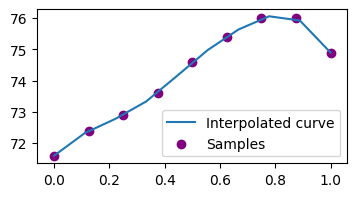

2022-12-12 20:33:35.696050: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-12 20:33:35.696216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-12 20:33:35.710554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 20:33:35.711607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.44GiB deviceMemoryBandwidth: 1.41TiB/s
2022-12-12 20:33:35.711632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-12 20:33:35.711681: I tensorflow/stream_executor/platform/defau

NameError: name 'interp_func_tf' is not defined

In [12]:
x = np.linspace(0, 1, 9)
y = np.asarray([71.6, 72.4, 72.9, 73.6, 74.6, 75.4, 76.0, 76.0, 74.9], np.float32)
# y = np.asarray([0 ,-0.55 ,-2.136 ,-4.366, -3.892  ], np.float32)
# y = np.asarray([0 ,3.2, 4.4, 3.9, 2.],np.float32) 
xs = np.linspace(0.0, 1, 10)
ys = interp(x, y, xs)
print(ys)

plt.figure(figsize = (4,2))
plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.legend()
plt.show()

with tf.compat.v1.Session() as ses:
  # Build a graph.
  x = tf.linspace(0., 1., 9, name='x')
  y = tf.constant([71.6, 72.4, 72.9, 73.6, 74.6, 75.4, 76.0, 76.0, 74.9],dtype = tf.float32) 
  xs = tf.linspace(0., 1., 10, name='xs')
  dothis = interp_func_tf(x,y,xs)
  
  print(ses.run(dothis))

# Raw script for B-spline math
# cubic hermite spline

In [ ]:
def h_poly_helper(tt):
  A = np.array([
    [1, 0, -3, 2],
    [0, 1, -2, 1],
    [0, 0, 3, -2],
    [0, 0, -1, 1]], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  # tt = [0 for _ in range(4) ]
  tt = [0,0,0,0 ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
 
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])

    m = np.concatenate([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
   
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
        return y[0] + np.zero(xs.shape)
    I = np.searchsorted(x[1:], xs)  # each xs belong to which spline segment
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

x = np.linspace(0, 1, 5)
# y = np.asarray([71.6, 72.4, 72.9, 73.6, 74.6, 75.4, 76.0, 76.0, 74.9], np.float32)
y = np.asarray([0 ,-0.55 ,-2.136 ,-4.366, -3.892  ], np.float32)
y = np.asarray([0 ,3.194, 4.431, 3.912, 1.998],np.float32) 
xs = np.linspace(0.04, 1, 25)
ys = interp(x, y, xs)
# print(xs, ys)

plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
# plt.plot(xs, np.asarray([np.sin(xx) for xx in xs], np.float32), '--', label='True Curve')
plt.legend()
plt.show()
